In [1]:
## Lesson 3 CamVid Tiramisu
%reload_ext autoreload
%autoreload 1
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
#import matplotlib.pyplot as plt

path = Path('/home/thor/notebooks/sensorx-contaminant-detection/data/')
path.ls()

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/codes.txt'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/valid.txt')]

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.51
fastprogress  : 0.1.20
torch         : 1.0.1
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7301 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.15.0-1041-azure-x86_64-with-debian-stretch-sid
distro        : #45-Ubuntu SMP Fri Mar 15 14:41:00 UTC 2019
conda env     : py35
python        : /data/anaconda/envs/py35/bin/python
sys.path      : /opt/caffe/python
/opt/caffe2/build
/data/home/thor/notebooks/sensorx-contaminant-detection
/data/anaconda/envs/py35/lib/python36.zip
/data/anaconda/envs/py35/lib/python3.6
/data/anaconda/envs/py35/lib/python3.6/lib-dynload

/data/anaconda/envs/py35/lib/python3.6/site-packages
/data/anaconda/envs/py35/lib/python3.6/site-packages/IPython/extensions
/data/home/thor/.ipython
```

Please make sure to include opening/closing ``` when you paste into foru

In [3]:
path_lbl = path/'masks'
path_img = path/'images'

In [4]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/images/MAGNA_48_-1CL_0.0481968kg.tif')]

In [5]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_46_83.231CL_3.48622kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_35_83.3273CL_2.92945kg.tif'),
 PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data/masks/MAGNA_48_-1CL_0.0481968kg.tif')]

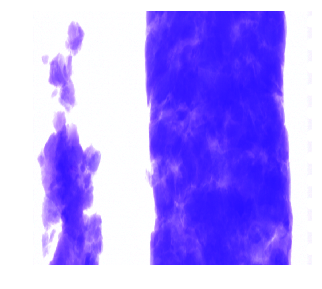

In [6]:
## Data

img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))
#plt.show()

In [7]:
img_f.parent.parent

PosixPath('/home/thor/notebooks/sensorx-contaminant-detection/data')

[700 768] tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


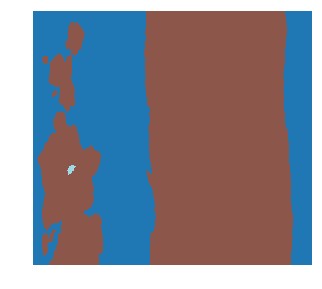

In [8]:
def get_y_fn(x):
    return Path(str(x.parent.parent)+'/masks') / x.name

codes = array(['Belt', 'Meat', 'Bone', 'Metal'])

mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

src_size = np.array(mask.shape[1:])
print(src_size, mask.data)

In [9]:
## Datasets
bs,size = 8,src_size//2

src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file(str(path) + '/valid.txt')
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

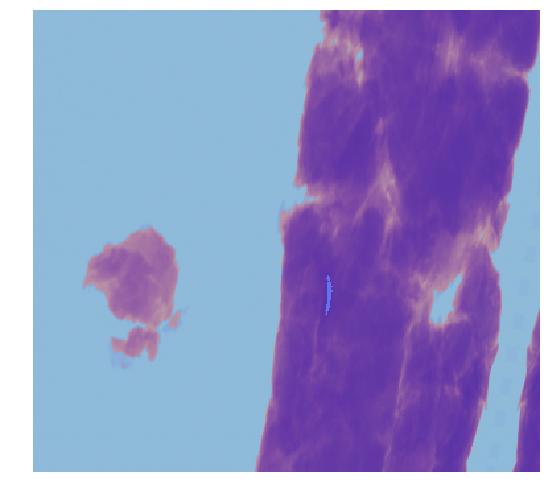

In [10]:
data.show_batch(1, figsize=(10,7))

In [11]:
name2id = {v:k for k,v in enumerate(codes)}

def error_measure(input, target):
    target = target.squeeze(1)
    mask_isVoid = target != name2id['Belt']
    mask_isBone = target == name2id['Bone']
    mask_ismetal = target == name2id['Metal']
    
    error = (input.argmax(dim=1)[mask_isVoid]!=target[mask_isVoid]).float().mean()
    boneError = input.argmax(dim=1)[mask_isBone]!=target[mask_isBone]
    metalError = input.argmax(dim=1)[mask_ismetal]!=target[mask_ismetal]
    if len(boneError) != 0:
        error += boneError.float().mean()
    if len(metalError) != 0:
        error += 4*metalError.float().mean()
    
    return error

In [12]:
# weights = torch.FloatTensor([0., 1., 10., 100.]) # ['Belt', 'Meat', 'Bone', 'Metal'])
# def forward(y_hat, y)->Rank0Tensor:  # This custom loss did not work with the backpropagation
#     y_hat = y_hat.argmax(dim=1)
#     y = y.squeeze(1)
    
#     costs = weights[y] * torch.log(y_hat.float() + 1e-16) # epsilon=1e-45
#     cost = costs.sum().double()
#     return cost

weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
def customLossFunction(input, target): # Works
    target = target.squeeze(1)
    return F.nll_loss(torch.log_softmax(input, 1), target, weight, reduction='mean')
    
# Works
class CustomLoss():
    "Weighted Cross Entropy Loss."
    
    def __init__(self):
        self.weight = torch.FloatTensor([1., 1., 1., 1.]).cuda()
        self.func = nn.CrossEntropyLoss(self.weight)
        functools.update_wrapper(self, self.func)

    def __repr__(self): return f"FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        target = target.squeeze(1)        
        return self.func.__call__(input, target, **kwargs)

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [14]:
def IoU(input:Tensor, targs:Tensor)->Rank0Tensor:
    return dice(input, targs, iou=True)

In [15]:
wd=1e-2

In [16]:
# The image is reduced by half (data.batch_stats), and has 3 chanels by default (the other two are set to 1)
learn = unet_learner(data, models.resnet34, metrics=error_measure, wd=wd)#, loss_func=nn.CrossEntropyLoss(weight))#, loss_func=CustomLoss()) #customLossFunction

learn.crit = FocalLoss(5.0)
learn.metrics=[dice, IoU]

# x, y = data.one_batch(DatasetType.Train, True, True)
# data.one_batch

In [17]:
# TODO: Set the new loss_func here
learn.loss_func, data.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of CrossEntropyLoss())

In [18]:
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


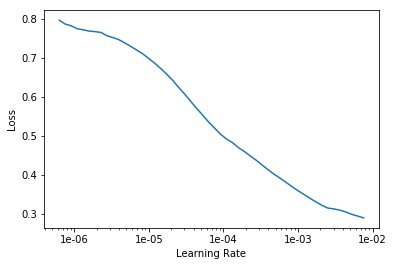

In [19]:
learn.recorder.plot()

In [20]:
lr=1e-4

In [21]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice,IoU,time
0,0.032404,0.013134,0.991311,0.982767,17:58
1,0.022681,0.008273,0.994719,0.989490,18:06
2,0.018084,0.006804,0.996160,0.992346,18:07
3,0.016084,0.007042,0.995867,0.991764,18:08
4,0.016691,0.006613,0.996085,0.992196,18:08
5,0.018255,0.006354,0.997188,0.994388,18:09
6,0.012506,0.005868,0.997021,0.994056,18:08
7,0.013896,0.006715,0.995839,0.991709,18:08
8,0.011481,0.005299,0.997181,0.994374,18:08
9,0.010573,0.004957,0.997406,0.994821,18:08


In [22]:
learn.save('stage-1-big')

In [23]:
learn.load('stage-1-big');

In [24]:
learn.unfreeze()

In [25]:
lrs = slice(1e-6,lr/10)

In [26]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,dice,IoU,time
0,0.010162,0.005034,0.997196,0.994404,18:50
1,0.010859,0.004984,0.997213,0.994437,18:51
2,0.010046,0.005032,0.997325,0.994659,18:50
3,0.010427,0.005264,0.997063,0.994139,18:51
4,0.010668,0.005029,0.997253,0.994517,18:51
5,0.009866,0.004830,0.997453,0.994915,18:51
6,0.009708,0.004867,0.997334,0.994677,18:51
7,0.009486,0.004822,0.997303,0.994615,18:51
8,0.009509,0.004801,0.997436,0.994881,18:51
9,0.010128,0.004920,0.997316,0.994642,18:51


In [27]:
learn.save('stage-2-big')

In [28]:
learn.load('stage-2-big');

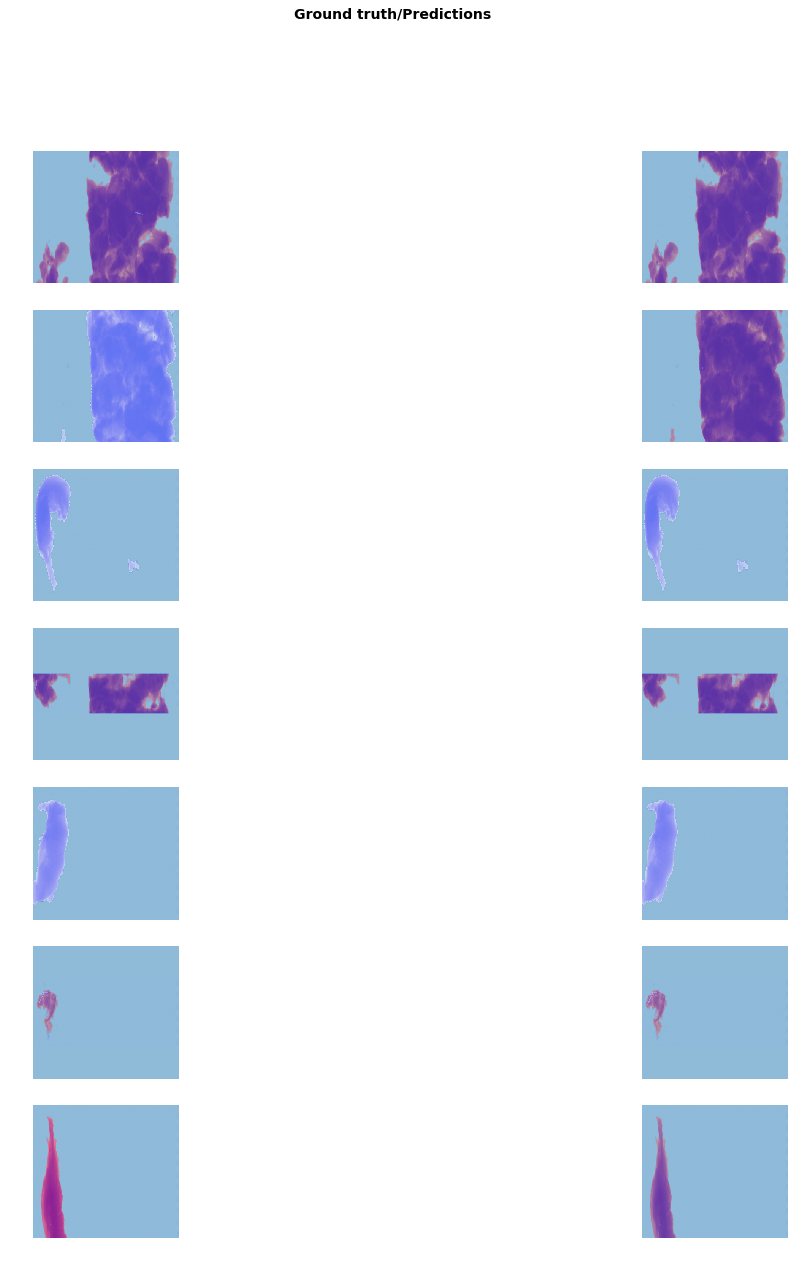

In [29]:
learn.show_results(rows=learn.data.batch_size-1, figsize=(20,20)) # This shows incorrect predictions?

In [30]:
preds,y = learn.get_preds()

In [31]:
def getContanimentInfo(prediction):
    items = prediction.unique()
    
    name2id = {v:k for k,v in enumerate(codes)}
    if name2id['Bone'] in items and name2id['Metal'] in items:
        return "Bone and Metal"
    if name2id['Metal'] in items:
        return "Metal"
    if name2id['Bone'] in items:
        return "Bone"
    if name2id['Meat'] in items:
        return "just Meat"
    else:
        return "Nothing"

########################
Ground truth / Predictions
########################
There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 55, Metal: 0
Prediction   -> Bone: 7, Metal: 0


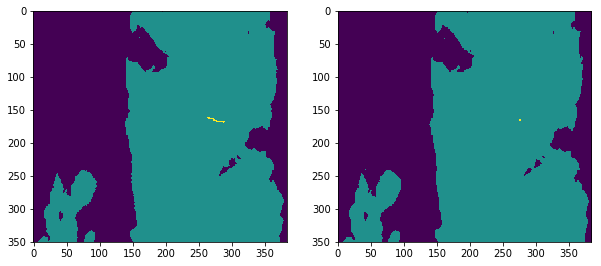

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 1
Prediction   -> Bone: 13, Metal: 0


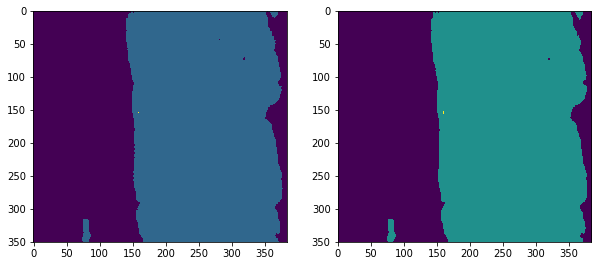

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2
Prediction   -> Bone: 5, Metal: 0


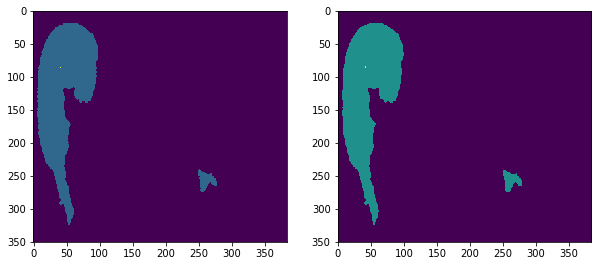

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 77, Metal: 0
Prediction   -> Bone: 11, Metal: 0


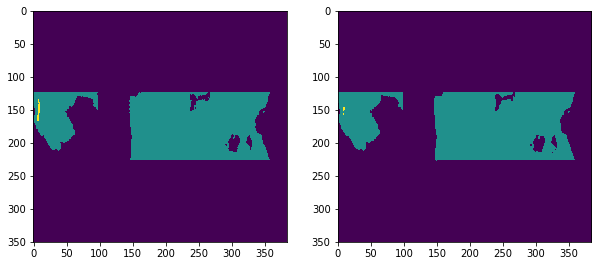

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2
Prediction   -> Bone: 3, Metal: 0


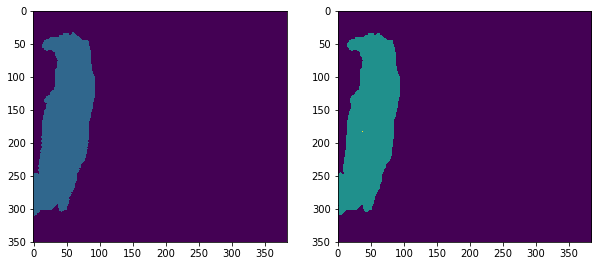

There is Bone / Found Bone
Pixel count
Ground truth -> Bone: 93, Metal: 0
Prediction   -> Bone: 111, Metal: 0


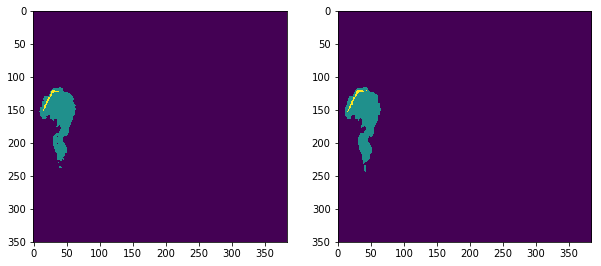

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2
Prediction   -> Bone: 8, Metal: 0


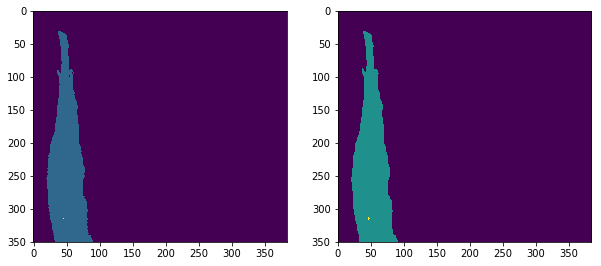

There is Metal / Found Bone
Pixel count
Ground truth -> Bone: 0, Metal: 2
Prediction   -> Bone: 11, Metal: 0


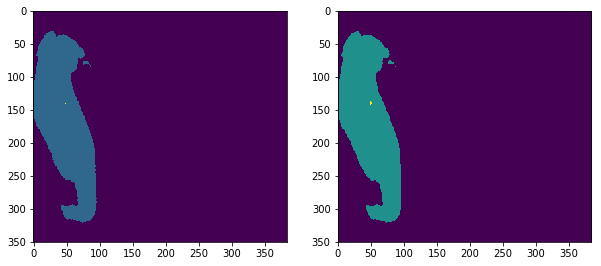

In [39]:
y = torch.squeeze(y)
print("########################")
print("Ground truth / Predictions")
print("########################")
for i in range(8): #learn.data.batch_size-1):
    prediction = preds.argmax(dim=1)[i]
    print("There is {} / Found {}".format(getContanimentInfo(y[i]), getContanimentInfo(prediction)))
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(1, 2, 1)
    plt.imshow(y[i])
    fig.add_subplot(1, 2, 2)
    plt.imshow(prediction)
    print("Pixel count")
    print("Ground truth -> Bone: {}, Metal: {}".format(len(y[i][y[i] == 2]), len(y[i][y[i] == 3])))
    print("Prediction   -> Bone: {}, Metal: {}".format(len(prediction[prediction == 2]), len(prediction[prediction == 3])))
    plt.show()
    